# UKESM1 Sample Loading
The purpose of this notebook is to load samples from ESM data into a file to be used as training data for GMM. The samples were created in GMMSampleCreator. Link to [Data analysis](#Data-Analysis).

TODO:
Generate and plot random samples, comparing distributions.

#### Dask

<br>

#### Choices for data

In [1]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r1i1p1f2", "r2i1p1f2", "r3i1p1f2"] #insert start of approved member_ids

#Custom Variables
levSel = slice(0, 2000) #Selected levels to be investigated
maxLat = -30 #Selected latitude to be investigated
maskName = "OceanMaskUKESM"
runIdSel = 0
lastESMDecade = slice('2005-01','2014-12')
sampleFileName = "GMMSampleTimeGeoUK2.npy"

<br>

#### Imports

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Data loading
<b>Loading ESM data</b>

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceId) & df.institution_id.eq(dataInstitutionId)]

memberArr = np.empty(shape=(0), dtype=bool)
for i in dfFilt["member_id"]:
    rowSel = i[:] in approvedIds #adapt i[:] to match size of approvedIds
    memberArr = np.append(memberArr, rowSel)

memberSer = pd.Series(memberArr, name='bools')
dfFilt = dfFilt[memberSer.values]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" "+dataSourceId+" data sets opened")
else:
    print("No UKESM data sets opened")
    
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunId') #Combining data sets
print("Data sets successfully merged")

dfESMLat = fileSet.thetao.where(fileSet.latitude < maxLat, drop=True) #Selection of latitude
dfESMLat = dfESMLat.rename({"latitude":"lat", "longitude":"lon"})
dfESMLatLev = dfESMLat.sel(lev=levSel) #Selects level data down to 2k
dfESMLatLevT = dfESMLatLev.sel(time=lastESMDecade)
dfESMLatLevTR = dfESMLatLevT.sel(RunId = runIdSel)
#dfESMLatLevT = dfESMLatLevT.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLatLevT["time"][0].values
globalDateInc = dfESMLatLevT["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLatLevT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("UKESM data loaded and stored in dfESMLatLevT")
#dfESMLatLevT #Uncomment to see data set

3 UKESM1-0-LL data sets opened
Data sets successfully merged
UKESM data loaded and stored in dfESMLatLevT


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<br>
<b>Calculating depth axis</b>

In [4]:
depthAxis = np.array(dfESMLatLevT.lev)
print("Depth axis calculated")

Depth axis calculated


<br>
<b>Loading ocean mask</b>

In [5]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded and stored in oceanMask")

Mask Loaded and stored in oceanMask


<br>
<b>Loading sample time and geo data</b>

In [6]:
sampleDataPoints = np.load(sampleFileName, allow_pickle=True)
print("GMM sample time and geo data loaded into sampleDataPoints")

GMM sample time and geo data loaded into sampleDataPoints


<br>

<br>
<b>Placing valid locations into an array</b><br>
Ocean mask here is used as it was generated from UKESM data, however it would be more accurate to use the UKESM sample data straight.

In [7]:
geoRangeLat = np.empty(shape=(0))
geoRangeLon = np.empty(shape=(0))
maskRef = oceanMask.copy()
for j in oceanMask["j"]:
    for i in oceanMask["i"]: 
        lookup = maskRef.where(maskRef["lat"] == maskRef["lat"][j][i].values, drop=True)
        lookup = lookup.where(lookup["lon"] == maskRef["lon"][j][i].values, drop=True)
        if not np.isnan(lookup.values[0][0][0]):
            geoRangeLat = np.append(geoRangeLat, oceanMask.lat[j][i].values)
            geoRangeLon = np.append(geoRangeLon, oceanMask.lon[j][i].values)
geoRange = np.append([geoRangeLat], [geoRangeLon], axis = 0) #Merges lat and lon arrays together into singular array
print("Valid locations identified and stored in geoRange")
#geoRange #Uncomment to see data array

Valid locations identified and stored in geoRange


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
</ul>

In [8]:
print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li>mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number.
<li>locationPlotSimple - Plots locations of an input data array on a map.
<li>locationPlot - Plots locations of an input data array on a map with a colour scale for time.
<li>latDistribution - Plots latitude distribution of an input data array as a histogram.
<li>latDistributionCompare - Plots latitude distribution of two input data arrays against each other as histograms.
<li>lonDistribution - Plots longitude distribution of an input data array as a histogram.
<li>lonDistributionCompare - Plots longitude distribution of two input data arrays against each other as histograms.
<li>timeDistribution - Plots time distribution of an input data array as a histogram.
<li>tempPointPlot - Plots the temperature profile of a single point against depth.
</ul>

In [9]:
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))
    
def locationPlotSimple(dataArray, size, plotNo):
    '''Plots locations of numpy arrays'''
    colours = {"2005":"Red", "2006":"Blue"}
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    plt.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), color = "Red")
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def locationPlotSimpleRec(dataArray, size, plotNo):
    '''Plots locations of numpy arrays'''
    plt.figure(plotNo, figsize=size)
    plt.scatter(dataArray[1], dataArray[0], color = "Red")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def locationPlot(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def latDistribution(dataArray, binSize, plotNo):
    '''Plots latitude distribution of input data array'''
    if not binSize: binSize = 2
    plt.figure(plotNo)
    latDistri = np.arange(-89.5, -29.4, binSize)
    plt.hist(dataArray[0], bins = latDistri)
    plt.title("Latitude distribution of data points (Bin size:"+str(binSize)+")")
    
def latDistributionCompare(dataArrayS, dataArrayO, binSize, plotNo):
    '''Plots and compares latitude distribution of input data arrays'''
    if not binSize: binSize = 2
    plt.figure(plotNo, figsize=(10,7))
    latDistri = np.arange(-89.5, -29.4, binSize)
    latWeightsS = np.ones_like(dataArrayS[0])/float(len(dataArrayS[0]))
    latWeightsO = np.ones_like(dataArrayO[0])/float(len(dataArrayO[0]))
    plt.hist(dataArrayS[0], bins = latDistri, weights = latWeightsS, alpha=0.5, label="Sampled data")
    plt.hist(dataArrayO[0], bins = latDistri, weights = latWeightsO, alpha=0.5, label="Original data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Latitude distribution of data points compared to original data set distribution (Bin size:"+str(binSize)+")")
    
def lonDistribution(dataArray, binSize, plotNo):
    '''Plots longitude distribution of input data array'''
    if not binSize: binSize = 3
    plt.figure(plotNo)
    lonDistri = np.arange(-180, 180.1, binSize)
    plt.hist(dataArray[1], bins = lonDistri)
    plt.title("Longitude distribution of data points (Bin size:"+str(binSize)+")")
    
def lonDistributionCompare(dataArrayS, dataArrayO, binSize, plotNo):
    '''Plots and compares longitude distribution of input data arrays'''
    if not binSize: binSize = 3
    plt.figure(plotNo, figsize=(10,7))
    lonDistri = np.arange(-180, 180.1, binSize)
    lonWeightsS = np.ones_like(dataArrayS[1])/float(len(dataArrayS[1]))
    lonWeightsO = np.ones_like(dataArrayO[1])/float(len(dataArrayO[1]))
    plt.hist(dataArrayS[1], bins = lonDistri, weights = lonWeightsS, alpha=0.5, label="Sampled data")
    plt.hist(dataArrayO[1], bins = lonDistri, weights = lonWeightsO, alpha=0.5, label="Original data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Longitude distribution of data points compared to original data set distribution (Bin size:"+str(binSize)+")")
    
def timeDistribution(dataArray, plotNo):
    plt.figure(plotNo)
    timeDistri = np.arange(np.datetime64("2005-01", "M"), np.datetime64("2015-02", "M")) #last date is excluded (max "2015-01"), 2014-12 needs monthly bin
    plt.hist(dataArray[2], bins = timeDistri)
    plt.title("Time distribution of data points")
    
def tempPointPlot(dataArray, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, depthAxis)
    plt.title(str(title))
    plt.gca().invert_yaxis()

print("Plotting functions defined")

Plotting functions defined


<br>

#### Displaying the mask and Range

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


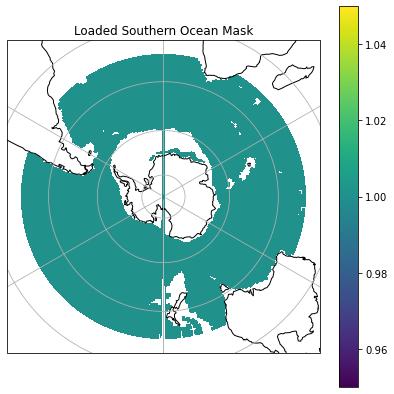

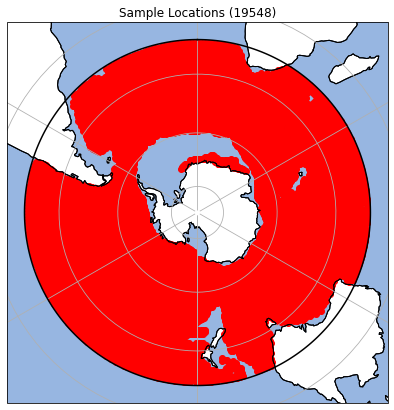

In [10]:
mapPlot(oceanMask, "Loaded Southern Ocean Mask", 1)
locationPlotSimple(geoRange, (7,7),2)

<br>

#### Loaded Samples time and geo properties

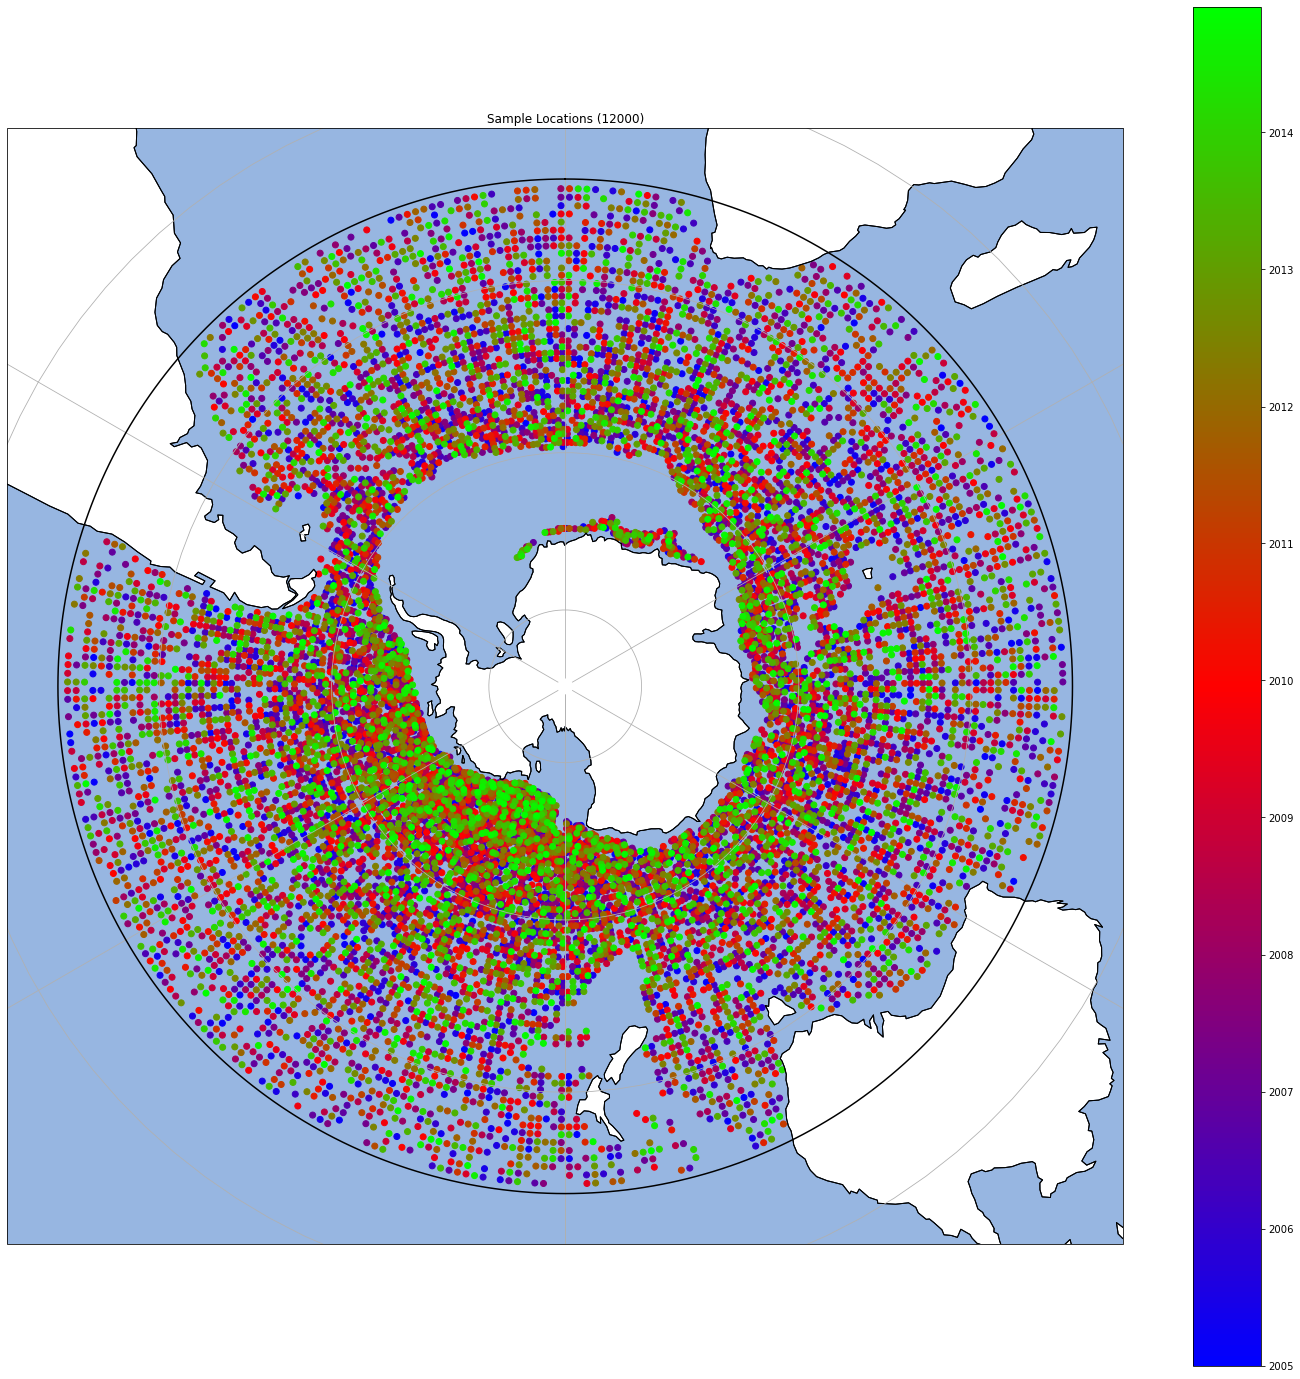

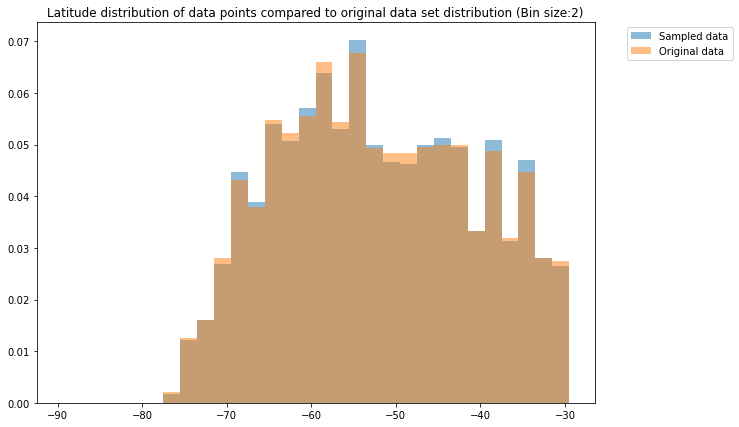

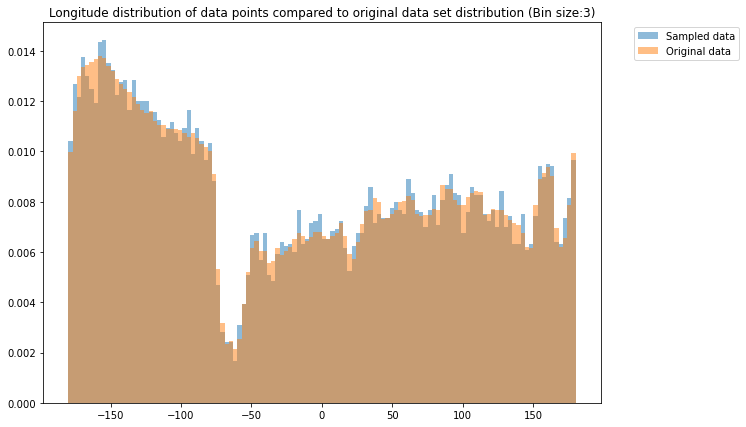

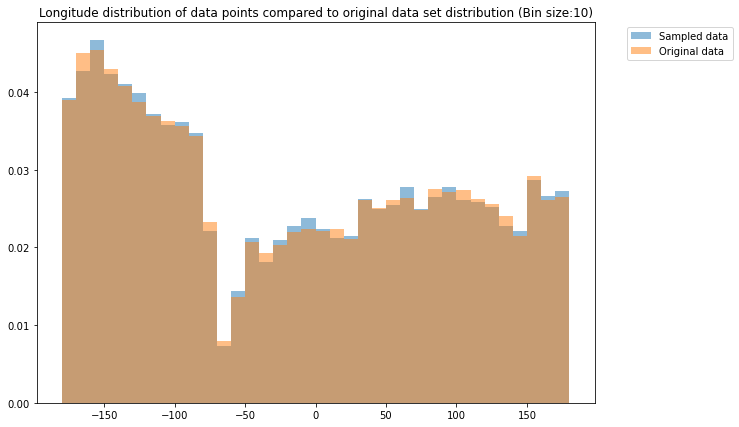

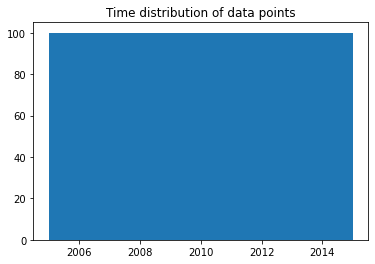

In [11]:
locationPlot(sampleDataPoints, (25,25), 1)
latDistributionCompare(sampleDataPoints, geoRange, 2, 2)
lonDistributionCompare(sampleDataPoints, geoRange, 3, 3)
lonDistributionCompare(sampleDataPoints, geoRange, 10, 4)
timeDistribution(sampleDataPoints, 5)

<br>

#### Data Analysis
<b>Extraction</b><br>

In [12]:
depthRange = len(dfESMLatLevTR.lev)
sampleTempArray = np.empty(shape=(0,depthRange))

sampleQuantity = len(sampleDataPoints[0])
breakDown = np.linspace(0, sampleQuantity, 13, dtype= int)
for j in range(len(breakDown)-1):
    sampleTempArrayPart = np.empty(shape=(0,46))
    for i in range(breakDown[j], breakDown[j+1]):
        sampleTempPart = np.empty(shape=(0,depthRange))
        sample = dfESMLatLevTR.sel(time=np.datetime64(sampleDataPoints[2][i]))
        sample = sample.where(dfESMLatLevTR.lat==sampleDataPoints[0][i], drop=True)
        sample = sample.where(dfESMLatLevTR.lon==sampleDataPoints[1][i], drop=True)
        sampleClean = sample.reset_coords(drop=True)
        sampleTempPart = np.append(sampleTempPart, sampleClean.values)
        sampleTempArray = np.append(sampleTempArray, [sampleTempPart], axis = 0) #1#exports data straight to main array
        #sampleTempArrayPart = np.append(sampleTempArray, [sampleTempPart], axis = 0) #2#exports to smaller array
    #sampleTempArray = np.append(sampleTempArray, [sampleTempArrayPart], axis = 0) #2#exports part to main array
    print("Finished "+str(breakDown[j+1]-1))

Finished 999
Finished 1999
Finished 2999
Finished 3999
Finished 4999
Finished 5999
Finished 6999
Finished 7999
Finished 8999
Finished 9999
Finished 10999
Finished 11999


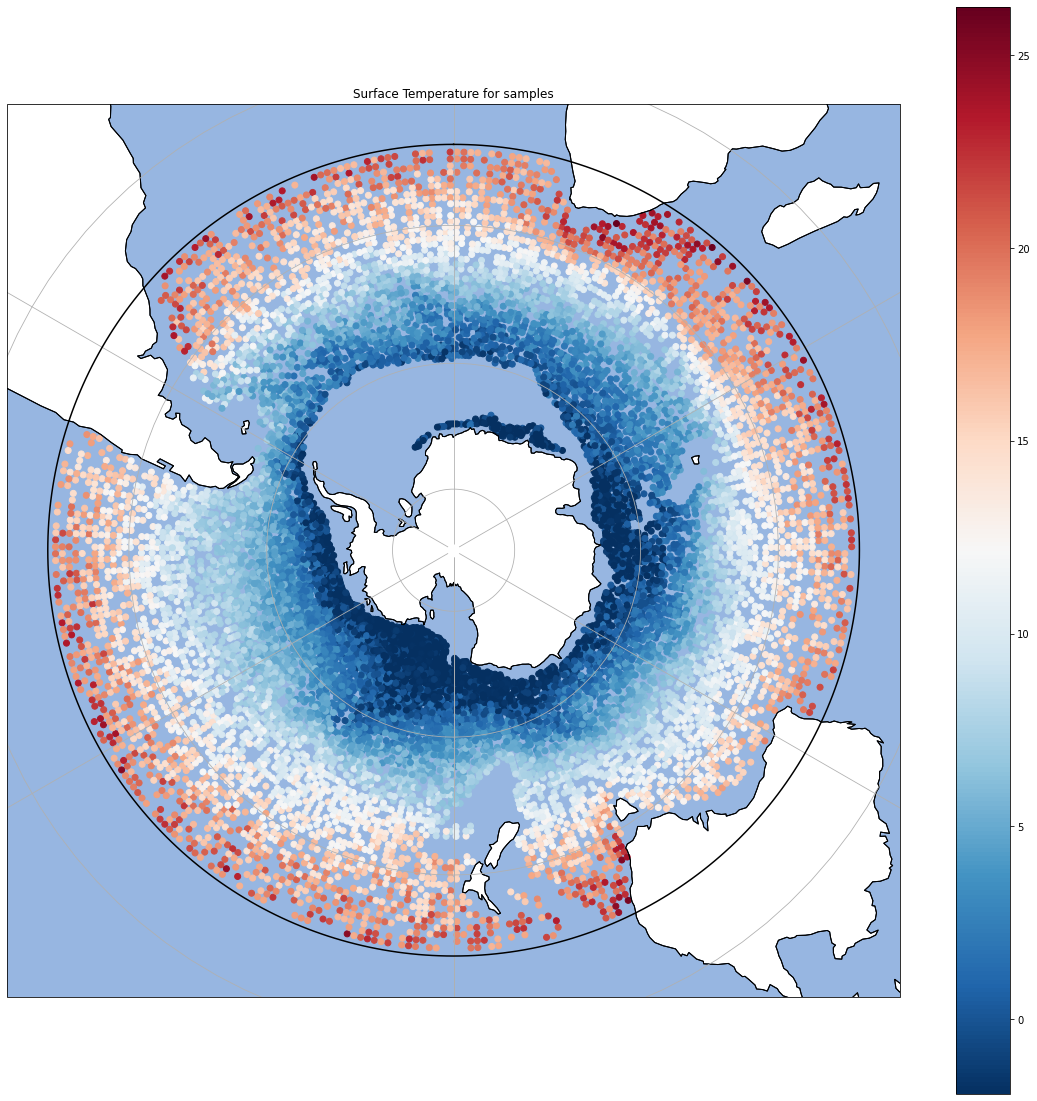

In [13]:
plt.figure(1, figsize=(20,20))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.coastlines()
ax.gridlines()
#im = ax.scatter(sampleDF["Lon"], sampleDF["Lat"], transform=ccrs.PlateCarree(), c =  sampleDF["labelSorted"], cmap='RdBu_r')
sampleTempArrayFlipped = np.transpose(sampleTempArray)
im = ax.scatter(sampleDataPoints[1], sampleDataPoints[0], transform=ccrs.PlateCarree(), c =  sampleTempArrayFlipped[0], cmap='RdBu_r')
cb = plt.colorbar(im)
plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
plt.title("Surface Temperature for samples")
plt.show()

<br>
<b>Plotting sample data points</b>

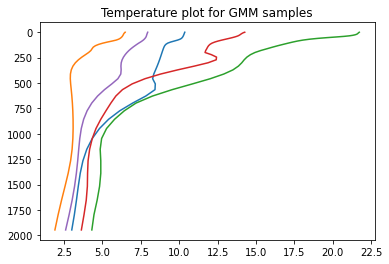

In [14]:
for j in range(5):
    tempPointPlot(sampleTempArray[j], "Temperature plot for GMM samples", 1)
#tempPointPlot(sampleTempArray[j], "Temperature plot at "+str(sampleDataPoints[0][j])+", "+str(sampleDataPoints[1][j])+"  "+str(sampleDataPoints[2][j]), 1)

<br>
<b>Exporting data</b>

In [15]:
exportFileName = sampleFileName[:9]+"DataL"+sampleFileName[-5:-4]

sampleTempArrayLabelled = depthAxis
sampleTempArrayLabelled = np.append([sampleTempArrayLabelled], sampleTempArray, axis = 0)

np.save(exportFileName, sampleTempArrayLabelled)
print("GMM Sample data exported to "+exportFileName+".")

GMM Sample data exported to GMMSampleDataL2.


<br>
<b>Reloading data</b>

In [16]:
reloadSampleTempArray = np.load(exportFileName+".npy")
print("Sample data reloaded into reloadSampleTempArray")

Sample data reloaded into reloadSampleTempArray


<br>
<b>Replotting sample data points</b><br>

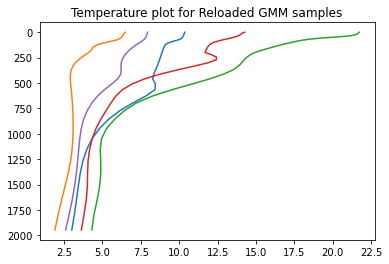

In [17]:
for j in range(1,6):
    tempPointPlot(reloadSampleTempArray[j], "Temperature plot for Reloaded GMM samples", 1)

<br>
<b>Data verification</b>

In [18]:
for i in range(10):
    x = np.random.randint(8000)
    print("Sample "+str(x))
    print(reloadSampleTempArray[x+1]-sampleTempArray[x])

Sample 5747
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Sample 223
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Sample 5408
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Sample 681
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Sample 761
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Sample 1887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 